## Подключение библиотек и пакетов

In [1]:
import numpy as np
import pandas as pd
import itertools
import os
from time import time

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка предобработанных данных

Настройка глобальных переменных



In [2]:
if 'google.colab' in str(get_ipython()):
    data_dir = os.path.join(os.getcwd(), '/content/data/weatherAUS')
else:
    data_dir = os.path.join(os.getcwd(), '../../../data/weatherAUS')


img_dir = os.path.join(os.getcwd(), 'img_svm')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

Загрузка данных с репозитория

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install rm
    !pip install wget
    !pip install gzip-reader
    !rm -r /content/data
    !wget -P data/weatherAUS https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/weatherAUS/weatherAUS_prepocessed.csv

Чтение и просмотр данных

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'weatherAUS_prepocessed.csv'))
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,17.7,35.1,0.0,9.8,12.9,72.0,15.0,33.0,63.0,13.0,...,0,1,0,0,0,0,0,0,0,0
1,18.5,23.0,0.0,11.0,5.9,63.0,15.0,35.0,63.0,58.0,...,0,0,0,1,0,0,0,0,0,0
2,18.7,27.1,0.0,5.4,11.3,65.0,24.0,48.0,60.0,51.0,...,0,0,0,0,0,0,0,0,0,0
3,20.2,31.6,0.0,10.0,12.2,63.0,11.0,35.0,58.0,52.0,...,0,0,0,0,0,0,0,0,0,0
4,19.9,29.7,0.0,10.0,11.8,41.0,19.0,20.0,82.0,54.0,...,0,0,0,0,0,0,0,0,0,0


Разделим данные на матрицу признаков и вектор ответов

In [5]:
y = df['RainTomorrow']
x = df.drop(['RainTomorrow'], axis=1)

Разделим данные на обучающие и тестовые выборки

In [6]:
from sklearn.model_selection import train_test_split

# разделение выборок на обучающую и тестовую в соотношении 75/25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

## Вспомогательные функции

Функция вычисления метрик при применении модели для тестовой выборки

In [7]:
# method - конкретный метод (модель)
# x_test - тестовая выборка признаков
# y_test - тестовая выборка ответов
def compute_metrics(y_test, y_pred=None, method=None, x_test=None):
  # применение модели на тестовой выборке
  if y_pred is None:
    y_pred = method.predict(x_test)

  # вычисление матрицы ошибок по векторам реальных результатом и 
  # результатов, данных моделью на тестовой выборке
  cfn_matrix = confusion_matrix(y_test, y_pred)

  # оценка точности классификации моделью персептрона
  accuracy = accuracy_score(y_test, y_pred)

  # вычисление точности (precision = TP / (TP + FP))
  precision = precision_score(y_test, y_pred)

  # вычисление полноты (recall = TP / (TP + FN))
  recall = recall_score(y_test, y_pred)

  # вычисление F-меры - средней гармонической precision и recall: 
  # F1 = 2 * (precision * recall) / (precision + recall)
  f1 = f1_score(y_test, y_pred)

  print('Точность классификации: %0.2f' % (accuracy))
  print('Точность (способность классификатора не отмечать один класс другим): %0.2f' % (precision))
  print('Полнота (отзыв, способность классификатора отмечать все объекты одного класса): %0.2f' % (recall))      
  print('F-мера (средневзвешенное значение точности и полноты): %0.2f' % (f1))

  # возвращаем матрицу ошибок
  return {'confusion_matrix': cfn_matrix, 'accuracy': accuracy, 
          'precision': precision, 'recall': recall, 'f1': f1}

Функция вывода графика матрицы ошибок

In [8]:
def plot_confusion_matrix(cm, classes, method_name: str, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  font = {'size' : 15}
  plt.rc('font', **font)
  plt.figure(figsize=(10, 8))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(f'{title}')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(f'{os.path.join(img_dir, title)}.png')
  plt.show()

Функция построения кривой AUC-ROC (площадь под кривой ошибок)

In [9]:
# функция построения кривой precision-recall и AOC-ROC
# x_test - тестовая выборка признаковых описаний
# y_test - тестовая выборка ответов
# lr_probs - предсказание работы алгоритма на тестовой выборке
# method_name - название метода
def plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name: str, title: str):
  ns_probs = [0 for _ in range(len(y_test))]

  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)

  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print(method_name + ': ROC AUC=%.3f' % (lr_auc))

  # вычисление AOC-ROC
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

  # построение графиков
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=method_name)

  # добавление подписей к осям
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # вывод графика
  plt.legend()
  plt.title(f'{title}')
  plt.savefig(f'{os.path.join(img_dir, title)}.png')
  plt.show()

Функция построения графика для определения влияния порога на оценку

In [10]:
# y_train - обучающая выборка ответов
# y_scores - предсказание работы алгоритма на обучающей выборке 
def plot_precision_recall_thresholds(y_train, y_scores, title: str):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

    plt.ylim([0,1])
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.title(f'{title}')
    plt.savefig(f'{os.path.join(img_dir, title)}.png')
    plt.show()

Функция построения графика кривой resicion-Recall

In [11]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title: str):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title}')
    plt.savefig(f'{os.path.join(img_dir, title)}.png')
    plt.show()

Функция получения лучших гиперпараметров через использование GridSearchCV

In [12]:
def get_best_params(model, x_train, y_train, param_grid, cv, scoring='accuracy'):
  search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
  results = search.fit(x_train, y_train)
  print('Mean Accuracy: %.3f' % results.best_score_)
  print('Config: %s' % results.best_params_)
  return results.best_params_

## Применение моделей
Подключение модулей

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score # проверка обучения модели кросс-валидацией
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix # для вычисления матрицы неточности
from sklearn.metrics import accuracy_score # для вычисления точности предсказывания
from sklearn.metrics import precision_score, recall_score, f1_score # для вычисления метрик (точность, полнота, F-мера и т.д.)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

### Модель SVM (метод опорных векторов) с гиперпараметрами по умолчанию

Подключение модуля SVM для решения задачи классификации

In [14]:
from sklearn.svm import SVC 

Создание и настройка модели SVM с гиперпараметрами по умолчанию. Обучение модели и вывод точности работы алгоритма на обучающей выборке. Вывод графика кривой Precision-Recall в процессе кросс-валидации

Точность работы модели (SVM) на обучающей выборке: 0.90
Время обучения модели (SVM) на обучающей выборке: 20.42 секунд
Время кросс-валидация модели (SVM) на обучающей выборке: 192.70 секунд


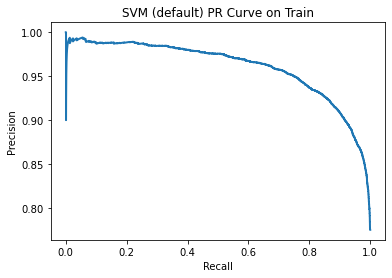

In [15]:
# создание и настройка модели SVM
# Взято количество максимальных итераций 20000, потому что при 10000 метод не сходился
clf_svm = make_pipeline(StandardScaler(), 
                        SVC(max_iter=20000, random_state=0, tol=1e-5))
# обучение модели
start_time = time()
clf_svm.fit(x_train, y_train)
end_time = time()
train_score = clf_svm.score(x_train, y_train)
print(f'Точность работы модели (SVM) на обучающей выборке: {train_score:.2f}')
print(f'Время обучения модели (SVM) на обучающей выборке: {(end_time - start_time):.2f} секунд')

# кросс-валидация и вычисление метрик на каждой итерации
start_time = time()
y_scores = cross_val_predict(clf_svm, x_train, y_train, cv=10, method="decision_function")
end_time = time()
print(f'Время кросс-валидация модели (SVM) на обучающей выборке: {(end_time - start_time):.2f} секунд')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
# вывод кривой Precision-Recall в процессе кросс-валидации
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,  
                      title='SVM (default) PR Curve on Train')

Вычисление метрик на тестовых данных и вывод матрицы ошибок

Точность классификации: 0.86
Точность (способность классификатора не отмечать один класс другим): 0.89
Полнота (отзыв, способность классификатора отмечать все объекты одного класса): 0.95
F-мера (средневзвешенное значение точности и полноты): 0.91
Confusion matrix, without normalization
[[ 678  494]
 [ 219 3805]]


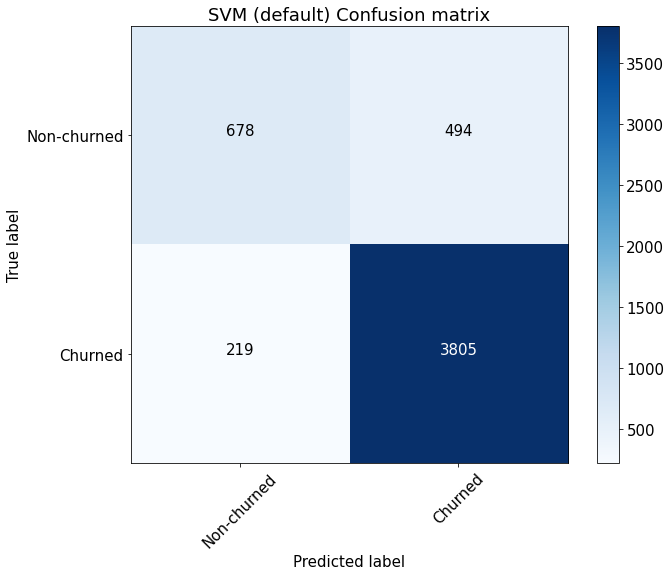

In [16]:
metrics = compute_metrics(method=clf_svm, x_test=x_test, y_test=y_test)
plot_confusion_matrix(metrics['confusion_matrix'], method_name='SVM', 
                      classes=['Non-churned', 'Churned'], 
                      title='SVM (default) Confusion matrix')

Построение кривой AUC-ROC (Area Under Curve - Receiver Operating Characteristic curve) - площадь под кривой ошибок

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.891


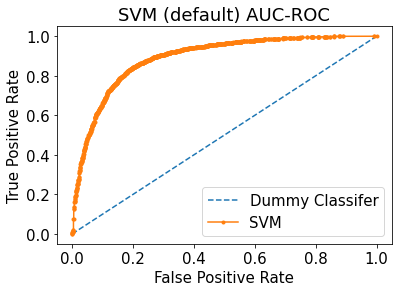

In [17]:
lr_probs = clf_svm.decision_function(x_test)
plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name='SVM',
                          title='SVM (default) AUC-ROC')

Вывод графика для определения влияния порога на оценку 



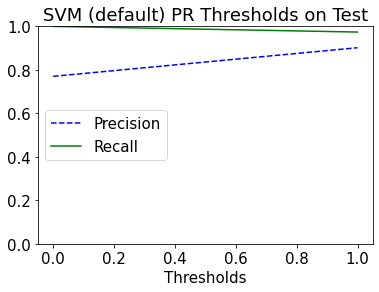

In [18]:
y_scores = clf_svm.predict(x_train)
plot_precision_recall_thresholds(y_train, y_scores, title='SVM (default) PR Thresholds on Test')

### Модель SVM (метод опорных векторов) с гиперпараметрами, подобранными с помощью GridSearchCV

Подключение нужных библиотек

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

Подбор лучших гиперпараметров с помощью GridSearchCV

In [20]:
# param_grid = { 
#    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#    'C': [0.1, 1, 10],
#    'max_iter': [-1],
# }

# clf = SVC()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# start_time = time()
# best_params = get_best_params(clf, x_train, y_train, param_grid, cv, scoring='accuracy')
# end_time = time()
# print(f'Время подбора параметров для модели (SVM) через использование GridSearchCV: {(end_time - start_time):.2f} секунд')

Mean Accuracy: 0.856
Config: {'C': 0.1, 'kernel': 'linear', 'max_iter': -1}
Время подбора параметров для модели (SVM) через использование GridSearchCV: 5007.46 секунд


Создание модели SVM с указанием лучший гиперпараметров, подобранных с помощью GridSearchCV. Обучение модели и вывод точности работы алгоритма на обуающей выборке. Вывод графика кривой Precision-Recall в процессе кросс-валидации

Точность работы модели (SVM) на обучающей выборке: 0.86
Время обучения модели (SVM) на обучающей выборке: 19.15 секунд
Время кросс-валидация модели (SVM) на обучающей выборке: 175.89 секунд


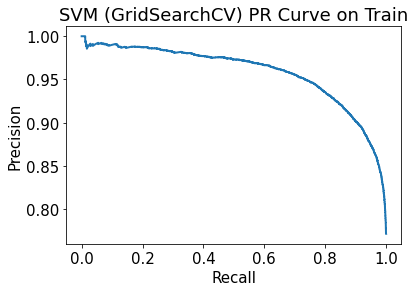

In [21]:
clf_smv_cv = make_pipeline(StandardScaler(), 
                           SVC(C=0.1, kernel='linear', max_iter=-1, random_state=0, tol=1e-5))
# обучение модели
start_time = time()
clf_smv_cv.fit(x_train, y_train)
end_time = time()
train_score = clf_smv_cv.score(x_train, y_train)
print(f'Точность работы модели (SVM) на обучающей выборке: {train_score:.2f}')
print(f'Время обучения модели (SVM) на обучающей выборке: {(end_time - start_time):.2f} секунд')

# кросс-валидация и вычисление метрик на каждой итерации
start_time = time()
y_scores = cross_val_predict(clf_smv_cv, x_train, y_train, cv=10, method="decision_function")
end_time = time()
print(f'Время кросс-валидация модели (SVM) на обучающей выборке: {(end_time - start_time):.2f} секунд')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
# вывод кривой Precision-Recall в процессе кросс-валидации
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,  
                      title='SVM (GridSearchCV) PR Curve on Train')

Вычисление метрик на тестовых данных и вывод матрицы ошибок

Точность классификации: 0.86
Точность (способность классификатора не отмечать один класс другим): 0.88
Полнота (отзыв, способность классификатора отмечать все объекты одного класса): 0.95
F-мера (средневзвешенное значение точности и полноты): 0.91
Confusion matrix, without normalization
[[ 669  503]
 [ 215 3809]]


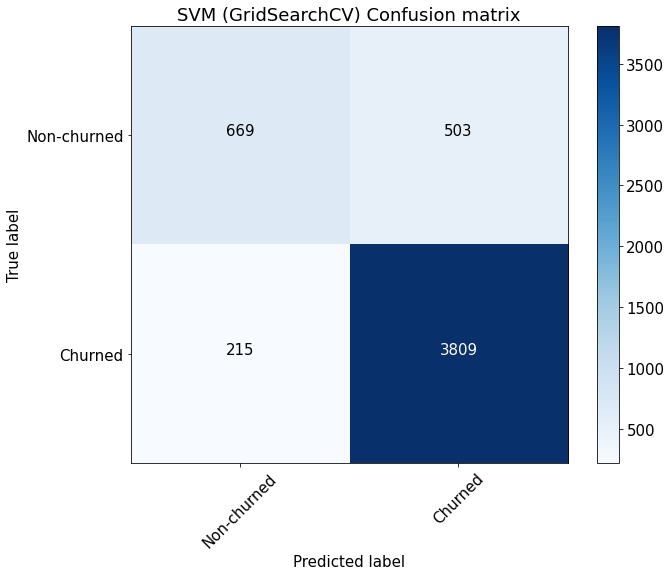

In [22]:
# вычисление метрик на тестовых данных и вывод матрицы ошибок
metrics = compute_metrics(method=clf_smv_cv, x_test=x_test, y_test=y_test)

plot_confusion_matrix(metrics['confusion_matrix'], method_name='SVM', 
                      classes=['Non-churned', 'Churned'], 
                      title='SVM (GridSearchCV) Confusion matrix')

Построение кривой AUC-ROC (Area Under Curve - Receiver Operating Characteristic curve) - площадь под кривой ошибок

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.893


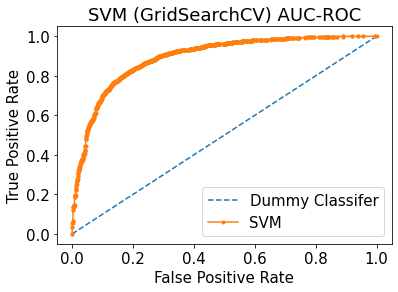

In [23]:
# построение кривой precision-recall и AOC-ROC
lr_probs = clf_smv_cv.decision_function(x_test)
plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name='SVM',
                          title='SVM (GridSearchCV) AUC-ROC')

Вывод графика для определения влияния порога на оценку 

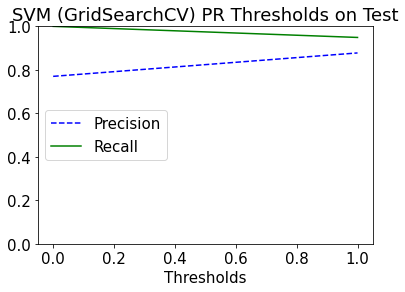

In [24]:
# вывод графика для определения влияния порога на оценку 
y_scores = clf_smv_cv.predict(x_train)
plot_precision_recall_thresholds(y_train, y_scores, title='SVM (GridSearchCV) PR Thresholds on Test')